In [2]:
import os

In [ ]:
# os.chdir('/content/drive/MyDrive/collab_data')

In [ ]:
!unzip /content/drive/MyDrive/eye_gender_data.zip

In [14]:
base_folder='/content/eye_gender_data'

In [15]:
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import image
print(tf.__version__)

2.8.0


In [16]:
df=pd.read_csv(os.path.join(base_folder,'Training_set.csv'))

In [17]:
df_test=pd.read_csv(os.path.join(base_folder,'Testing_set.csv'))

In [18]:
df.head()

,filename,label
0,Image_1.jpg,male
1,Image_2.jpg,female
2,Image_3.jpg,female
3,Image_4.jpg,female
4,Image_5.jpg,male


In [19]:
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
from keras.models import Sequential
from tensorflow.keras import optimizers

In [20]:
def to_grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    return image

In [30]:
datagen=ImageDataGenerator(rescale=1./255.,
                           validation_split=0.2,
                           preprocessing_function=to_grayscale,
)

In [31]:
train_generator=datagen.flow_from_dataframe(dataframe=df,directory=base_folder+"/train/",x_col="filename",y_col="label",subset="training",batch_size=64,seed=42,shuffle=True,class_mode="binary",target_size=(32,32))
valid_generator=datagen.flow_from_dataframe(dataframe=df,directory=base_folder+"/train/",x_col="filename",y_col="label",subset="validation",batch_size=64,seed=42,shuffle=True,class_mode="binary",target_size=(32,32))

Found 7376 validated image filenames belonging to 2 classes.
Found 1844 validated image filenames belonging to 2 classes.


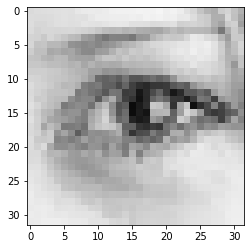

In [32]:
plt.imshow(train_generator[0][0][0])
plt.show()

In [24]:
test_datagen=ImageDataGenerator(rescale=1./255.,preprocessing_function=to_grayscale)

In [25]:
test_generator=test_datagen.flow_from_dataframe(dataframe=df_test,directory=base_folder+"/test/",x_col="filename",y_col=None,batch_size=64,seed=42,shuffle=False,class_mode=None,target_size=(32,32))

Found 2305 validated image filenames.


In [26]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(32,32,3),activation='relu'))

model.add(Conv2D(32, (3, 3),activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))

model.add(Conv2D(64, (3, 3),activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128,activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))

model.add(Dense(32,activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(16,activation='relu'))

model.add(Dense(8,activation='relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss="binary_crossentropy",metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                        

In [33]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [34]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, 
                                               restore_best_weights=True,
                                               verbose=1)

In [35]:
history=model.fit(train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=valid_generator,
          validation_steps=STEP_SIZE_VALID,
          epochs=100,verbose=1,
          callbacks=[es_callback])

Epoch 1/100
115/115 [==============================] - 18s 161ms/step - loss: 0.2726 - accuracy: 0.8883 - val_loss: 0.2962 - val_accuracy: 0.8681
Epoch 2/100
115/115 [==============================] - 19s 162ms/step - loss: 0.2489 - accuracy: 0.8969 - val_loss: 0.2532 - val_accuracy: 0.8989
Epoch 3/100
115/115 [==============================] - 18s 161ms/step - loss: 0.2464 - accuracy: 0.8995 - val_loss: 0.2883 - val_accuracy: 0.8720
Epoch 4/100
115/115 [==============================] - 19s 163ms/step - loss: 0.2399 - accuracy: 0.9026 - val_loss: 0.2541 - val_accuracy: 0.9010
Epoch 5/100
115/115 [==============================] - 18s 161ms/step - loss: 0.2118 - accuracy: 0.9134 - val_loss: 0.2356 - val_accuracy: 0.9071
Epoch 6/100
115/115 [==============================] - 18s 161ms/step - loss: 0.2157 - accuracy: 0.9140 - val_loss: 0.2312 - val_accuracy: 0.9123
Epoch 7/100
115/115 [==============================] - 18s 161ms/step - loss: 0.1984 - accuracy: 0.9216 - val_loss: 0.2206 -

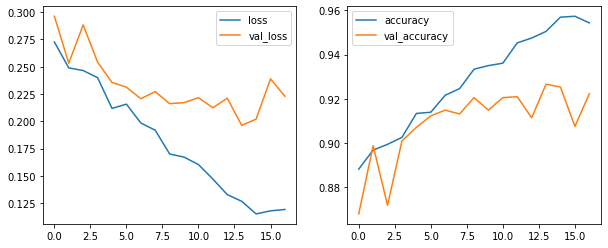

In [36]:


import pandas as pd

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);



In [37]:
model.evaluate(valid_generator,steps=STEP_SIZE_VALID)

28/28 [==============================] - 3s 118ms/step - loss: 0.2169 - accuracy: 0.9202


[0.216893270611763, 0.9202008843421936]

In [43]:
test_generator.n

2305

In [ ]:
test

In [44]:
pred=model.predict(test_generator,verbose=1)

37/37 [==============================] - 7s 189ms/step


In [45]:
pred.shape

(2305, 1)

In [54]:
pred[9]

array([1.7474489e-06], dtype=float32)

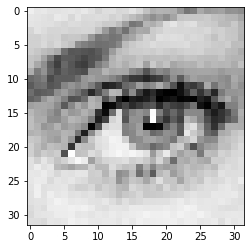

In [55]:
plt.imshow(test_generator[0][9])
plt.show()

In [56]:
labels=[]

In [57]:
for x in pred:
  if x>0.5:
    labels.append('male')
  else:
    labels.append('female')

In [58]:
df_predicted=pd.DataFrame({'label':labels})

In [59]:
df_predicted

,label
0,male
1,female
2,male
3,male
4,male
...,...
2300,female
2301,female
2302,male
2303,male


In [60]:
df_predicted.to_csv("results.csv",index=False)